In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import pandas as pd
import numpy as np
import re
import pickle

In [26]:
# Load your datasets
train = pd.read_csv('/content/IMDB_train_dataset.csv')
test = pd.read_csv('/content/IMDB_test_dataset.csv')

In [3]:
train.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
test.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
print("Train columns:", train.columns)
print("Test columns:", test.columns)

Train columns: Index(['review', 'sentiment'], dtype='object')
Test columns: Index(['review', 'sentiment'], dtype='object')


In [6]:
if 'review' in train.columns:
    train.rename(columns={'review': 'content'}, inplace=True)
if 'review' in test.columns:
    test.rename(columns={'review': 'content'}, inplace=True)
if 'sentiment' in train.columns:
    train.rename(columns={'sentiment': 'sentiment'}, inplace=True)
if 'sentiment' in test.columns:
    test.rename(columns={'sentiment': 'sentiment'}, inplace=True)

In [7]:
print("Train columns:", train.columns)
print("Test columns:", test.columns)

Train columns: Index(['content', 'sentiment'], dtype='object')
Test columns: Index(['content', 'sentiment'], dtype='object')


In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

In [9]:
# Apply text cleaning
train['content'] = train['content'].apply(clean_text)
test['content'] = test['content'].apply(clean_text)

In [10]:
# Map sentiments to binary values
sentiment_mapping = {'positive': 1, 'negative': 0}
train['sentiment'] = train['sentiment'].map(sentiment_mapping)
test['sentiment'] = test['sentiment'].map(sentiment_mapping)

In [11]:
# Prepare text and labels
X_train = train['content'].values
y_train = train['sentiment'].values
X_test = test['content'].values
y_test = test['sentiment'].values

In [12]:
# Tokenize the text data
max_words = 25000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [13]:
# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [14]:
# Define max sequence length
max_sequence_length = 100

# Pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')


In [15]:
with open("tokenizer.pkl", "wb") as handle:
   pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
# Define the model
embedding_dim = 100
lstm_units = 64

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=lstm_units))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Output layer with binary classification

In [17]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2500000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2544353 (9.71 MB)
Trainable params: 2544353 (9.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Define checkpoint callback
checkpoint_filepath = '/content/best_model.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [27]:
# Train the model
model.fit(
    X_train_padded,        # Padded training data
    y_train,               # Training labels
    validation_data=(X_test_padded, y_test),  # Validation data
    epochs=10,
    batch_size=64,
    callbacks=[model_checkpoint]
)

Epoch 1/10
625/625 [==============================] - 131s 207ms/step - loss: 0.1577 - accuracy: 0.9443 - val_loss: 0.4067 - val_accuracy: 0.8450
Epoch 2/10
625/625 [==============================] - 117s 186ms/step - loss: 0.1047 - accuracy: 0.9651 - val_loss: 0.4435 - val_accuracy: 0.8594
Epoch 3/10
625/625 [==============================] - 117s 187ms/step - loss: 0.0877 - accuracy: 0.9720 - val_loss: 0.6043 - val_accuracy: 0.8526
Epoch 4/10
625/625 [==============================] - 118s 188ms/step - loss: 0.0563 - accuracy: 0.9814 - val_loss: 0.7357 - val_accuracy: 0.8547
Epoch 5/10
625/625 [==============================] - 125s 200ms/step - loss: 0.0387 - accuracy: 0.9883 - val_loss: 0.7044 - val_accuracy: 0.8524
Epoch 6/10
625/625 [==============================] - 124s 198ms/step - loss: 0.0373 - accuracy: 0.9883 - val_loss: 0.6681 - val_accuracy: 0.8472
Epoch 7/10
625/625 [==============================] - 125s 200ms/step - loss: 0.0323 - accuracy: 0.9906 - val_loss: 0.8580 -

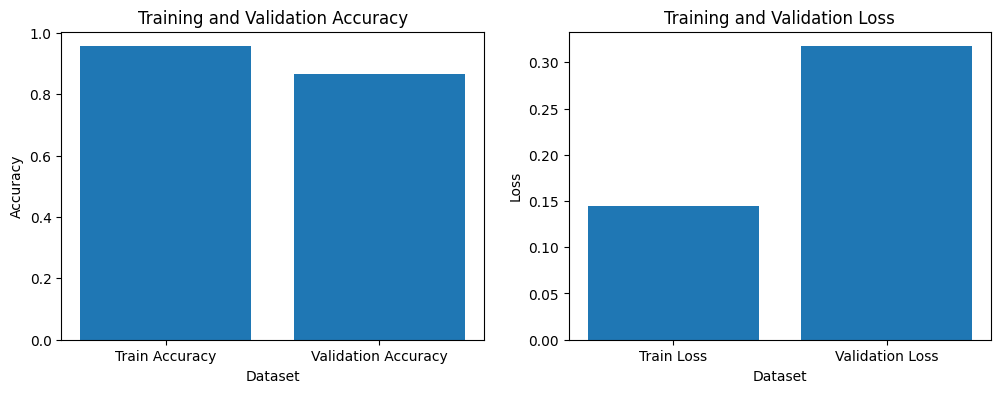

In [28]:
# Load the trained model
model = tf.keras.models.load_model('/content/best_model.h5')

# Evaluate the model on the training and validation data
train_loss, train_accuracy = model.evaluate(X_train_padded, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
import matplotlib.pyplot as plt
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_accuracy, val_accuracy])
plt.title('Training and Validation Accuracy')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.bar(['Train Loss', 'Validation Loss'], [train_loss, val_loss])
plt.title('Training and Validation Loss')
plt.xlabel('Dataset')
plt.ylabel('Loss')

plt.show()